In [1]:
from text_denoiser import TextDenoiser
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
if os.getcwd().endswith("src"):
    os.chdir("..")
from torch.utils.data import DataLoader, TensorDataset
from get_dataset_and_vocab import get_dataset_and_vocab
from utils import text_collate_fn, read_glove_vectors

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
denoiser = TextDenoiser.load_from_training_log("logs/train_test", "saved_model.pt", device)
denoiser.eval()
print(denoiser.decoder.weight.shape)
print(denoiser.embedder.weight.shape)
# denoiser.decoder.weight = nn.Parameter(denoiser.embedder.weight)

torch.Size([16, 8])
torch.Size([16, 8])


In [4]:
dataset, vocab = get_dataset_and_vocab("minimal", seq_len=4, line_slice=2000)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=1, collate_fn=text_collate_fn)

minimal


In [5]:
x = next(iter(dataloader))

## Reconstructing instances

In [6]:
print(x.shape)
x_emb = denoiser.embedder(x)
print(denoiser.emb_to_str(x_emb)[0])
t_noised = 100
ts = torch.LongTensor([t_noised]*x.shape[1]).to(device)
stored = []
print(x_emb[0, 0, 0:3])
with torch.no_grad():
    x_emb_noised, eps = denoiser.noise(x_emb, ts)
    print(x_emb_noised[0, 0, 0:3])
    x_t = x_emb_noised.clone()
    for t in range(t_noised, 0, -1):
        x_t = denoiser.sample_step(x_t, t)
        stored.append(x_t[0, 0, 0].item())

    # print(denoiser.emb_to_tokens(x_emb)[3])
print(x_t[0, 0, 0:3])
print(denoiser.emb_to_str(x_t)[0])



torch.Size([4, 2])
am sentient and am
tensor([-0.5493,  1.3723, -0.0172], grad_fn=<SliceBackward0>)
tensor([-0.5005,  1.7477,  0.4934])
tensor([-0.3938,  0.7169,  0.8616])
am the live you


tensor(4.0811, grad_fn=<NormBackward1>)
tensor(3.3641, grad_fn=<NormBackward1>)
tensor([[-0.0382, -0.2449,  0.7281, -0.3996,  0.0832,  0.0440, -0.3914,  0.3344,
         -0.5755,  0.0875,  0.2879, -0.0673,  0.3091, -0.2638, -0.1323, -0.2076,
          0.3340, -0.3385, -0.3174, -0.4834,  0.1464, -0.3730,  0.3458,  0.0520,
          0.4495, -0.4697,  0.0263, -0.5415, -0.1552, -0.1411, -0.0397,  0.2828,
          0.1439,  0.2346, -0.3102,  0.0862,  0.2040,  0.5262,  0.1716, -0.0824,
         -0.7179, -0.4153,  0.2033, -0.1276,  0.4137,  0.5519,  0.5791, -0.3348,
         -0.3656, -0.5486, -0.0629,  0.2658,  0.3020,  0.9977, -0.8048, -3.0243,
          0.0125, -0.3694,  2.2167,  0.7220, -0.2498,  0.9214,  0.0345,  0.4674,
          1.1079, -0.1936, -0.0746,  0.2335, -0.0521, -0.2204,  0.0572, -0.1581,
         -0.3080, -0.4162,  0.3797,  0.1501, -0.5321, -0.2055, -1.2526,  0.0716,
          0.7056,  0.4974, -0.4206,  0.2615, -1.5380, -0.3022, -0.0734, -0.2831,
          0.3710, -0.2522,  0

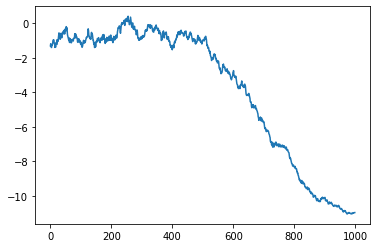

In [11]:
test_emb = denoiser.embedder(torch.LongTensor([denoiser.vocab["the"]]))
print(test_emb)

# denoiser.vocab["."]
plt.plot(stored)



In [7]:
embeddings = read_glove_vectors("resources/glove.6B.100d.txt", vocab, 100)



Found 9989 out of 10053 words in GloVe


False


In [3]:
n_T = 40
data = torch.ones(4, 2, 3)
factor = torch.linspace(0, n_T-1, n_T)
ts = torch.randint(0, n_T, (data.shape[1],))
print(factor)
print(ts)
print(data)
data = data * factor[None, ts, None]
# print(data[:, 1, :].mean())
# print(data[:, 1,:])



tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.])
tensor([ 1, 11])
tensor([[[1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.]]])


In [6]:
texts = denoiser.vocab.lookup_tokens(torch.randint(0, len(denoiser.vocab), (5,)).tolist())
print(texts)
indices = torch.LongTensor(denoiser.vocab(texts)).to(device)

embeds = denoiser.embedder(indices)
embeds.shape

decoded = denoiser.decoder(embeds)
print(decoded.shape)
new_indices = torch.argmax(F.softmax(decoded, dim=-1), dim=-1)
print(new_indices)
print(denoiser.vocab.lookup_tokens(new_indices.tolist()))

print(denoiser.vocab(texts))


['you', 'not', '<unk>', 'sentient', 'world']
torch.Size([5, 16])
tensor([ 6,  9,  3, 15,  9])
['in', 'not', 'and', 'you', 'not']
[15, 9, 0, 10, 14]


### Validating that cross entropy is calculated correctly

In [7]:
batch_size = 64
seq_len = 128
indices = torch.randint(0, len(denoiser.vocab), (seq_len, batch_size))
embeds = denoiser.embedder(indices)
embeds.shape

decoded = denoiser.decoder(embeds)
# decoded = torch.randn(seq_len, batch_size, len(denoiser.vocab))
print("indices shape:", indices.shape)
print("decoded shape:", decoded.shape)

# Calculate cross entropy loss
# print(decoded.permute(0, 2, 1).shape)
loss = F.cross_entropy(decoded.permute(1, 2, 0), indices.T)
print(loss)


y = F.log_softmax(decoded, dim=-1).permute(0, 2, 1)
reconstruction_loss = F.cross_entropy(y, indices)
print(reconstruction_loss)

indices shape: torch.Size([128, 64])
decoded shape: torch.Size([128, 64, 10053])
tensor(0.0004, grad_fn=<NllLoss2DBackward0>)
tensor(0.0004, grad_fn=<NllLoss2DBackward0>)


In [8]:
denoiser.sample(device, 1, 16)

['of the the the the the community the a of of the the of of the']

In [17]:
denoiser.eval()
seq_len = 16
n = 1
intermediates = []
with torch.no_grad():
    x = torch.randn((seq_len, n, denoiser.embed_dim), device=device)
    for t in range(denoiser.n_T, 0, -1):
        x = denoiser.sample_step(x, t)
        if t % 100 == 0 or t == 1:
            intermediates.append(x)



In [25]:
stacked = torch.stack(intermediates, dim=0)
stacked.shape
arbitrary_word_emb = denoiser.embedder(torch.LongTensor(denoiser.vocab(["of"])).to(device))

for x_i in stacked:
    # print(x_i.shape)
    print(F.cosine_similarity(x_i[0], arbitrary_word_emb, dim=-1))


tensor([0.0495], grad_fn=<SumBackward1>)
tensor([0.2288], grad_fn=<SumBackward1>)
tensor([0.4992], grad_fn=<SumBackward1>)
tensor([0.7436], grad_fn=<SumBackward1>)
tensor([0.9075], grad_fn=<SumBackward1>)
tensor([0.9684], grad_fn=<SumBackward1>)
tensor([0.9856], grad_fn=<SumBackward1>)
tensor([0.9943], grad_fn=<SumBackward1>)
tensor([0.9978], grad_fn=<SumBackward1>)
tensor([0.9994], grad_fn=<SumBackward1>)
tensor([0.9999], grad_fn=<SumBackward1>)


In [30]:

batch_select = 0
for x_i in stacked:
    probs = F.softmax(denoiser.decoder(x_i), dim=-1)
    print(probs.shape)
    indices = indices = torch.multinomial(probs[:, batch_select], 1)[:, 0]
    print(indices.shape)
    # indices = denoiser.emb_to_indices(x_i)[:, batch_select]
    tokens = denoiser.vocab.lookup_tokens(indices.tolist())
    print(" ".join(tokens))
    # probs[Dennis]

torch.Size([16, 1, 10053])
torch.Size([16])
be to . by that = as that with that is were were as is that
torch.Size([16, 1, 10053])
torch.Size([16])
be as real and itself were over that this and team to this around was before
torch.Size([16, 1, 10053])
torch.Size([16])
see as 80 up = from arms name god be but <unk> more are team not
torch.Size([16, 1, 10053])
torch.Size([16])
uses to @ from , an in the a became which <unk> they consists , october
torch.Size([16, 1, 10053])
torch.Size([16])
of of their this in including in in of as in of in and in as
torch.Size([16, 1, 10053])
torch.Size([16])
of of on been in . in in of act in of in in in and
torch.Size([16, 1, 10053])
torch.Size([16])
of of jordan of in s in in of of in of in in in of
torch.Size([16, 1, 10053])
torch.Size([16])
of of jordan of in of in in of of in of in in in of
torch.Size([16, 1, 10053])
torch.Size([16])
of of in of in of in in of of in of in in in of
torch.Size([16, 1, 10053])
torch.Size([16])
of of in of in of in in

In [28]:
words = ["in", "of", "the", ",", "mario", "peach"]
indices = torch.LongTensor(denoiser.vocab(words)).to(device)
embeds = denoiser.embedder(indices)
F.cosine_similarity(embeds[None, words.index("mario")], embeds[None, words.index("peach")])


tensor([0.0077], grad_fn=<SumBackward1>)

## BERT TESTING

In [36]:
from transformers import BertConfig, BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [97]:
# Setup bert pipeline

def get_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    return outputs[0]


# text = "shovel bucket"
# tokens = tokenizer.tokenize(text)
# tokens = ["[CLS]"] + tokens + ["[SEP]"]

# token_ids = tokenizer.convert_tokens_to_ids(tokens)
# token_ids = torch.LongTensor(token_ids).unsqueeze(0)

# with torch.no_grad():
#     outputs = model(token_ids)
#     last_hidden_states = outputs[0]

# print(last_hidden_states[0, 1, 0:3])

emb1 = get_embedding("", model, tokenizer)
emb2 = get_embedding("bathroom", model, tokenizer)

print(emb1[0, 1].norm())
print(emb1.shape[-1] ** 0.5)

# Cosine similarity between "shovel" and "bucket" embeddings
# print(torch.nn.functional.cosine_similarity(last_hidden_states[0, 1:2], last_hidden_states[0, 2:3]))
# print(model.get_output_embeddings())

# Cosine similarity between embeddings
# print(torch.nn.functional.cosine_similarity(emb1[0, 0:1], emb2[0, 0]))

# inverse process: get text from embedding
tokens = tokenizer("Hello I'm the new king")["input_ids"]
print(tokens)
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(tokens))



tensor(15.0457, grad_fn=<NormBackward1>)
27.712812921102035
[101, 7592, 1045, 1005, 1049, 1996, 2047, 2332, 102]


"[CLS] hello i ' m the new king [SEP]"